# **Sentiment Analysis**

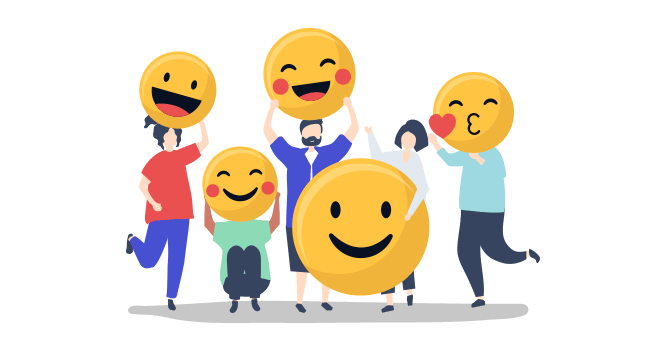

> The code here are divided in 2 parts


*   Done from scratch
*   Used different algorithms to compare results










All the important libraries are loaded in first step




In [1]:
import pandas as pd 
import numpy as np 
from collections import defaultdict
import re
import json, nltk
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import accuracy_score
%matplotlib inline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes Classifier



# **Naive Bayes from Scratch**

In [2]:
    '''
        Data Loading:
        ----------
        The data is loaded from a tsv file
        ---------

        Line Skipping : 
        ----------
        There were few bugs in the dataset like pandas was not able to load quotes in a the same line so "quoting=csv.QUOTE_NONE" was used.
    '''
    
training_set = pd.read_csv('./train.tsv', error_bad_lines=False,quoting=csv.QUOTE_NONE, sep='\t', header=None, engine='python')
training_set
training_set.columns = ['sentiment', 'review']
training_set = training_set[pd.notnull(training_set['review'])]
training_set.head()


Skipping line 55429: Expected 2 fields in line 55429, saw 3


,sentiment,review
0,0,@USER @USER a sicrhau bod mwy o arian poced 'd...
1,1,Parti Dolig da gyda tim swyddfa canolog @USER ...
2,0,@USER yeaah ma fe yn wir. ( oh well.
3,1,@USER hahaha idk. 3am oedd y bws ti?
4,0,@USER dwim yn gal llun ohoni?


In [3]:
def preprocess_string(str_arg):
    
    """"
        Parameters:
        ----------
        str_arg: example string to be preprocessed
        
        What the function does?
        -----------------------
        Preprocess the string argument - str_arg - such that :
        1. everything apart from letters is excluded
        2. multiple spaces are replaced by single space
        3. str_arg is converted to lower case 
        
        Example:
        --------
        Input :  Menu is absolutely perfect,loved it!
        Output:  ['menu', 'is', 'absolutely', 'perfect', 'loved', 'it']
        

        Returns:
        ---------
        Preprocessed string 
        
    """
    
    cleaned_str=re.sub('[^a-z\s]+',' ',str_arg,flags=re.IGNORECASE) #every char except alphabets is replaced
    cleaned_str=re.sub('(\s+)',' ',cleaned_str) #multiple spaces are replaced by single space
    cleaned_str=cleaned_str.lower() #converting the cleaned string to lower case
    
    return cleaned_str # eturning the preprocessed string in tokenized form

In [4]:
class NaiveBayes:
    
    def __init__(self,unique_classes):
        
        self.classes=unique_classes # Constructor is simply passed with unique number of classes of the training set
        

    def addToBow(self,example,dict_index):
        
        '''
            Parameters:
            1. example 
            2. dict_index - implies to which BoW category this example belongs to

            What the function does?
            -----------------------
            It simply splits the example on the basis of space as a tokenizer and adds every tokenized word to
            its corresponding dictionary/BoW

            Returns:
            ---------
            Nothing
        
       '''
        
        if isinstance(example,np.ndarray): example=example[0]
     
        for token_word in example.split(): #for every word in preprocessed example
          
            self.bow_dicts[dict_index][token_word]+=1 #increment in its count
            
    def train(self,dataset,labels):
        
        '''
            Parameters:
            1. dataset - shape = (m X d)
            2. labels - shape = (m,)

            What the function does?
            -----------------------
            This is the training function which will train the Naive Bayes Model i.e compute a BoW for each
            category/class. 

            Returns:
            ---------
            Nothing
        
        '''
    
        self.examples=dataset
        self.labels=labels
        self.bow_dicts=np.array([defaultdict(lambda:0) for index in range(self.classes.shape[0])])
        
        #only convert to numpy arrays if initially not passed as numpy arrays - else its a useless recomputation
        
        if not isinstance(self.examples,np.ndarray): self.examples=np.array(self.examples)
        if not isinstance(self.labels,np.ndarray): self.labels=np.array(self.labels)
            
        #constructing BoW for each category
        for cat_index,cat in enumerate(self.classes):
          
            all_cat_examples=self.examples[self.labels==cat] #filter all examples of category == cat
            
            #get examples preprocessed
            
            cleaned_examples=[preprocess_string(cat_example) for cat_example in all_cat_examples]
            
            cleaned_examples=pd.DataFrame(data=cleaned_examples)
            
            #now costruct BoW of this particular category
            np.apply_along_axis(self.addToBow,1,cleaned_examples,cat_index)
            
                
        ###################################################################################################
        
        '''
            ------------------------------------------------------------------------------------
            Computing : {for each word w [ count(w|c)+1 ] / [ count(c) + |V| + 1 ] } * p(c)
            ------------------------------------------------------------------------------------
            
            We are done with constructing of BoW for each category. But we need to precompute a few 
            other calculations at training time too:
            1. prior probability of each class - p(c)
            2. vocabulary |V| 
            3. denominator value of each class - [ count(c) + |V| + 1 ] 
            
        '''
        
        ###################################################################################################
      
        prob_classes=np.empty(self.classes.shape[0])
        all_words=[]
        cat_word_counts=np.empty(self.classes.shape[0])
        for cat_index,cat in enumerate(self.classes):
           
            #Calculating prior probability p(c) for each class
            prob_classes[cat_index]=np.sum(self.labels==cat)/float(self.labels.shape[0]) 
            
            #Calculating total counts of all the words of each class 
            count=list(self.bow_dicts[cat_index].values())
            cat_word_counts[cat_index]=np.sum(np.array(list(self.bow_dicts[cat_index].values())))+1 # |v| is remaining to be added
            
            #get all words of this category                                
            all_words+=self.bow_dicts[cat_index].keys()
                                                     
        
        #combine all words of every category & make them unique to get vocabulary -V- of entire training set
        
        self.vocab=np.unique(np.array(all_words))
        self.vocab_length=self.vocab.shape[0]
                                  
        #computing denominator value                                      
        denoms=np.array([cat_word_counts[cat_index]+self.vocab_length+1 for cat_index,cat in enumerate(self.classes)])                                                                          
      
        '''
            Every element of self.cats_info has a tuple of values
            Each tuple has a dict at index 0, prior probability at index 1, denominator value at index 2
        '''
        
        self.cats_info=[(self.bow_dicts[cat_index],prob_classes[cat_index],denoms[cat_index]) for cat_index,cat in enumerate(self.classes)]                               
        self.cats_info=np.array(self.cats_info)                                 
                                              
                                              
    def getExampleProb(self,test_example):                                
        
        '''
            Parameters:
            -----------
            1. a single test example 

            What the function does?
            -----------------------
            Function that estimates posterior probability of the given test example

            Returns:
            ---------
            probability of test example in ALL CLASSES
        '''                                      
                                              
        likelihood_prob=np.zeros(self.classes.shape[0]) #to store probability w.r.t each class
        
        #finding probability w.r.t each class of the given test example
        for cat_index,cat in enumerate(self.classes): 
                             
            for test_token in test_example.split(): #split the test example and get p of each test word
                
                ####################################################################################
                                              
                #This loop computes : for each word w [ count(w|c)+1 ] / [ count(c) + |V| + 1 ]                               
                                              
                ####################################################################################                              
                
                #get total count of this test token from it's respective training dict to get numerator value                           
                test_token_counts=self.cats_info[cat_index][0].get(test_token,0)+1
                
                #now get likelihood of this test_token word                              
                test_token_prob=test_token_counts/float(self.cats_info[cat_index][2])                              
                
                #taking log: To prevent underflow!
                likelihood_prob[cat_index]+=np.log(test_token_prob)
                                              
        # we have likelihood estimate of the given example against every class but we need posterior probility
        post_prob=np.empty(self.classes.shape[0])
        for cat_index,cat in enumerate(self.classes):
            post_prob[cat_index]=likelihood_prob[cat_index]+np.log(self.cats_info[cat_index][1])                                  
      
        return post_prob
    
   
    def test(self,test_set):
      
        '''
            Parameters:
            -----------
            1. A complete test set of shape (m,)
            

            What the function does?
            -----------------------
            Determines probability of each test example against all classes and predicts the label
            against which the class probability is maximum

            Returns:
            ---------
            Predictions of test examples - A single prediction against every test example
        '''       
       
        predictions=[] #to store prediction of each test example
        for example in test_set: 
                                              
            #preprocess the test example the same way we did for training set exampels                                  
            cleaned_example=preprocess_string(example) 
             
            #simply get the posterior probability of every example                                  
            post_prob=self.getExampleProb(cleaned_example) #get prob of this example for both classes
            
            #simply pick the max value and map against self.classes!
            predictions.append(self.classes[np.argmax(post_prob)])
                
        return np.array(predictions)

In [5]:

    '''
        Splitting dataset as we don't have seperate test dataset:
        -----------
        We used sklearn library to split the dataset randomly in to parts
        train : 80%
        test : 20%

        The reason of using a libary was to make sure we have a proper shuffled dataset after splitting. We could have used defined function to do this but this helped in getting better dataset.
    '''

#getting training set examples labels
y_train=training_set['sentiment'].values
x_train=training_set['review'].values
print ("Unique Classes: ",np.unique(y_train))
print ("Total Number of Training Examples: ",x_train.shape)    

from sklearn.model_selection import train_test_split
train_data,test_data,train_labels,test_labels=train_test_split(x_train,y_train,shuffle=True,test_size=0.2,random_state=42,stratify=y_train)
classes=np.unique(train_labels)




Unique Classes:  ['0' '1']
Total Number of Training Examples:  (79999,)


In [6]:
'''
        Training: 
        -----------
        We will be training our model here.
        '''
nb=NaiveBayes(classes)
print ("------------------Training In Progress------------------------")
print ("Training Examples: ",train_data.shape)
nb.train(train_data,train_labels)
print ('------------------------Training Completed!')

------------------Training In Progress------------------------
Training Examples:  (63999,)
------------------------Training Completed!


# **Different Algorithms**

In [7]:
#Assigning column names into variables
tweet = training_set.columns.values[1]
sentiment = training_set.columns.values[0]
tweet, sentiment

('review', 'sentiment')

**Preprocessing**

Convert every tweets to lower case

*   Remove @USER username
*   Remove punctuations, numbers and special characters
*   Convert more than 2 letter repetitions to 2 letter ( example (coooool --> cool))
*   Remove extra spaces
* Remove @URL
* Emoji analysis






In [8]:
# A function which handles emoji classification

def emoji(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' positiveemoji ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', tweet)
    return tweet

In [9]:
# A function which will preprocess the tweets
def process_tweet(tweet):
    tweet = tweet.lower()                                             # Lowercases the string
    tweet = re.sub('@[^\s]+', '', tweet)                              # Removes usernames
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet)   # Remove URLs
    tweet = re.sub(r"\d+", " ", str(tweet))                           # Removes all digits
    tweet = re.sub('&quot;'," ", tweet)                               # Remove (&quot;) 
    tweet = emoji(tweet)                                              # Replaces Emojis
    tweet = re.sub(r"\b[a-zA-Z]\b", "", str(tweet))                   # Removes all single characters
    tweet = re.sub(r"[^\w\s]", " ", str(tweet))                       # Removes all punctuations
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)                         # Convert more than 2 letter repetitions to 2 letter
    tweet = re.sub(r"\s+", " ", str(tweet))                           # Replaces double spaces with single space    
    return tweet

In [10]:
# A new column for side by side comparison of new tweets vs old tweets
training_set['processed_tweet'] = np.vectorize(process_tweet)(training_set[tweet])
training_set.head(10)


,sentiment,review,processed_tweet
0,0,@USER @USER a sicrhau bod mwy o arian poced 'd...,sicrhau bod mwy arian poced da ti nes fe ti e...
1,1,Parti Dolig da gyda tim swyddfa canolog @USER ...,parti dolig da gyda tim swyddfa canolog ty gwy...
2,0,@USER yeaah ma fe yn wir. ( oh well.,yeaah ma fe yn wir oh well
3,1,@USER hahaha idk. 3am oedd y bws ti?,hahaha idk am oedd bws ti
4,0,@USER dwim yn gal llun ohoni?,dwim yn gal llun ohoni
5,0,@USER desparate housewives! Dadla be di gora h...,desparate housewives dadla be di gora heno gw...
6,1,@USER Diolch! Dweud wrtho Manon fi wedi txto h...,diolch dweud wrtho manon fi wedi txto hi
7,0,@USER mar boy yn hymian o nappies. Dwim isho s...,mar boy yn hymian nappies dwim isho siarad ef...
8,1,"@USER mor browd, fe fyddai yn dangos ti faint ...",mor browd fe fyddai yn dangos ti faint mor aw...
9,0,"being a grown-up sucks, dw i 'sho mynd i Vfest .",being grown up sucks dw sho mynd vfest


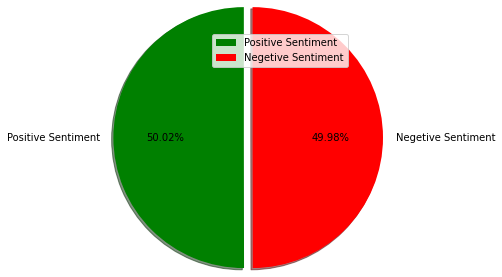

In [11]:
'''
    Analysing sentements on the basis of the data given
    0 : Negative
    1 : Positive
'''

sentiments = ['Positive Sentiment', 'Negetive Sentiment'] 
slices = [(training_set[sentiment] == '1').sum(), (training_set[sentiment] == '0').sum()] 
colors = ['g', 'r'] 
plt.pie(slices, labels = sentiments, colors=colors, startangle=90, shadow = True,
        explode = (0, 0.1), radius = 1.5, autopct = '%1.2f%%') 
plt.legend()
plt.show()

In [12]:
'''
      We have to extract or convert the text data into numbers without losing much of the information. 
      One way to do such transformation is Bag-Of-Words (BOW) which gives a number to each word but that is very inefficient. 
      So, a way to do it is by CountVectorizer: it counts the number of words in the document 
      i.e it converts a collection of text documents to a matrix of the counts of occurences of each word in the document.
'''

from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(ngram_range=(1,2))    # Unigram and Bigram
final_vectorized_data = count_vectorizer.fit_transform(training_set['review'])  
final_vectorized_data

<79999x532794 sparse matrix of type '<class 'numpy.int64'>'
	with 1981728 stored elements in Compressed Sparse Row format>

In [13]:
    '''
        Splitting dataset as we don't have seperate test dataset:
        -----------
        We used sklearn library to split the dataset randomly in to parts
        train : 80%
        test : 20%
    '''

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_vectorized_data, training_set[sentiment], test_size=0.2, random_state=69)

In [14]:
print("X_train_shape : ",X_train.shape)
print("X_test_shape : ",X_test.shape)
print("y_train_shape : ",y_train.shape)
print("y_test_shape : ",y_test.shape)

X_train_shape :  (63999, 532794)
X_test_shape :  (16000, 532794)
y_train_shape :  (63999,)
y_test_shape :  (16000,)


There are some popular classifiers under Naive Bayes

*   Bernoulli Naive Bayes

*  Gaussian Naive Bayes classifier
*  Multinomial Naive Bayes





We will use **Multinomial Naive Bayes classifier**

In [15]:

model_naive = MultinomialNB().fit(X_train, y_train) 
predicted_naive = model_naive.predict(X_test)

Here we **LogisticRegression** to compare accuracy. 

Regularization (C) = 0.5 gave best accuracy. 

We tested for C = [0.01, 0.05, 0.25, 0.5, 1]

In [16]:
lr = LogisticRegression(C=0.5,max_iter=7600,solver='lbfgs')
lr.fit(X_train, y_train)


LogisticRegression(C=0.5, max_iter=7600)

In [19]:
def evaluate():
  #Calculating accuracy for Scratch part :
  print ("------------------Navive Bayes from Scratch------------------------")
  pclasses=nb.test(test_data)
  test_acc=np.sum(pclasses==test_labels)/float(test_labels.shape[0])
  print ("Accuracy with Navive Bayes from Scratch: ",test_acc)

  print('\n')

  #Calculating accuracy for Multinomial Naive Bayes :
  print ("------------------Multinomial Naive Bayes------------------------")
  score_naive = accuracy_score(predicted_naive, y_test)
  print("Accuracy with Multinomial Naive Bayes: ",score_naive)

  print('\n')

  #Calculating accuracy for Logistic Regression :
  print ("------------------Logistic Regression------------------------")
  score_logistic = accuracy_score(y_test, lr.predict(X_test))
  print("Accuracy with Logistic Regression: ",score_logistic)

  

In [20]:
evaluate()

------------------Navive Bayes from Scratch------------------------
Accuracy with Navive Bayes from Scratch:  0.736125


------------------Multinomial Naive Bayes------------------------
Accuracy with Multinomial Naive Bayes:  0.7465


------------------Logistic Regression------------------------
Accuracy with Logistic Regression:  0.7591875


In [ ]:
# def evaluate():
#   total = 0
#   correct_from_scratch = 0
#   correct_anything_goes = 0
#   testfile = open('test.tsv', 'r')
#   for line in testfile:
#     total += 1
#     pieces = line.rstrip("\n").split("\t")
#     if nb.test(pieces[1]) == int(pieces[0]):
#       correct_from_scratch += 1
#     if predict_anything_goes(pieces[1]) == int(pieces[0]):
#       correct_anything_goes += 1
#   return (correct_from_scratch/total, correct_anything_goes/total)